# **Analysis for Light/Dark protocol**

## This analysis script is well suited to analyse the data from the light/dark protocol: 20min initial baseline light + multiple times off/on + final light baseline.

load modules

In [1]:
%load_ext autoreload

%autoreload 2
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
from spikeA.Session import *
from spikeA.Spike_train_loader import Spike_train_loader
from spikeA.Cell_group import Cell_group
from spikeA.Animal_pose import Animal_pose
from spikeA.Session import Session

set session name

In [2]:
# name="pk3864-10022022-0101"
# name="pk3864-11022022-0101"
# name="pk3864-16022022-0101"
name="pk3864-21022022-0101"

Check the path

In [3]:
import os

basedir = "/adata/electro"
subject, session = name.split("-",1)
path = basedir+"/"+subject+"/"+name+"/"

fname = name.split("_")[0]

print("Path:", path)
print("Mouse:", subject) # directory = mouse subject name
print("Session:", session)
print("Name:", name, ",", fname)
print("")
print("Path:", "OK" if os.path.isdir(path) else "invalid")

Path: /adata/electro/pk3864/pk3864-21022022-0101/
Mouse: pk3864
Session: 21022022-0101
Name: pk3864-21022022-0101 , pk3864-21022022-0101

Path: OK


## Get a Session object

Check the files

In [4]:
ses = Kilosort_session(name=fname, path=path)
ses.load_parameters_from_files(ignore_params=True)  # ignore_params if kilosort has not been executed so far
print(ses)

<class 'spikeA.Session.Kilosort_session'>
name = pk3864-21022022-0101
path = /adata/electro/pk3864/pk3864-21022022-0101
subject = pk3864
session_dat_time = 2022-02-21 01:01:00
fileBase = /adata/electro/pk3864/pk3864-21022022-0101/pk3864-21022022-0101
file_names = {'par': '/adata/electro/pk3864/pk3864-21022022-0101/pk3864-21022022-0101.par', 'desen': '/adata/electro/pk3864/pk3864-21022022-0101/pk3864-21022022-0101.desen', 'desel': '/adata/electro/pk3864/pk3864-21022022-0101/pk3864-21022022-0101.desel', 'sampling_rate': '/adata/electro/pk3864/pk3864-21022022-0101/pk3864-21022022-0101.sampling_rate_dat', 'stimulation': '/adata/electro/pk3864/pk3864-21022022-0101/pk3864-21022022-0101.stimulation', 'px_per_cm': '/adata/electro/pk3864/pk3864-21022022-0101/pk3864-21022022-0101.px_per_cm', 'setup': '/adata/electro/pk3864/pk3864-21022022-0101/pk3864-21022022-0101.setup', 'environmentFamiliarity': '/adata/electro/pk3864/pk3864-21022022-0101/pk3864-21022022-0101.environmentFamiliarity', 'params':

## Load spikes

In [5]:
stl = Spike_train_loader()
stl.load_spike_train_kilosort(ses)
print("stl.clu_ids",stl.clu_ids)
cg = Cell_group(stl)

stl.clu_ids [  0   3   5  14  15  20  21  23  31  32  33  34  44  47  48  49  54  55
  56  59  61  62  75  99 107 113]


## Load the waveforms

Set the waveform and channel information from the session template file.

In [6]:
cg.set_info_from_session(ses, maxchannels=5)

Templates: 115 , timepoints: 82 , Channels: 64
Loaded templates-clusters-map, spikes: 3729266 , clusters: 115
Init shanks: 8


For each cluster, print the active channels where the spikes were detected, and the corresponding brain area.

In [7]:
unique, counts = np.unique([ '/'.join(n.brain_area) for n in cg.neuron_list ] , return_counts=True )

for u,c in zip(unique, counts):
    print(u,":",c)

adn : 21
adn/mec : 1
mec : 4


## Create a pose file 

In [8]:
ap = Animal_pose(ses)
posefilename = ses.fileBase + ap.pose_file_extension
print("look for", posefilename)
if not os.path.exists(posefilename):
    print("load from positrack")
    extension = ap.positrack_type()
    print("use extension:",extension)
    ap.pose_from_positrack_files(ses=ses, interpolation_frequency_hz = 50, extension=extension)
    ap.save_pose_to_file() # save the file for next time
else:
    print("load from saved pose file")
    ap.load_pose_from_file()

look for /adata/electro/pk3864/pk3864-21022022-0101/pk3864-21022022-0101.pose.npy
load from saved pose file


In [9]:
ap.invalid_ratio()

0.18514800989626287

In [10]:
# find good shape automagically & crop
diameter=90.
xyrange_min,xyrange_max=ap.find_xy_range(diameter=diameter)  ###-> do this within intervals , for each trial + use min/max to find best square that covers most of the area
xmean,ymean = ap.meanloc
print("xmean,ymean",xmean,ymean)
print("xyrange_min,xyrange_max",xyrange_min,xyrange_max)

xmean,ymean 40.40929984113307 77.13820423462016
xyrange_min,xyrange_max [ 2. 47.] [ 92. 137.]


Plot the path of the animal to see if it was loaded correctly.

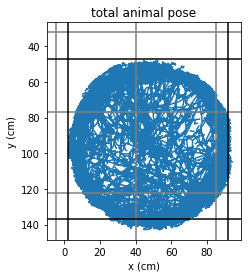

In [11]:
plt.plot(ap.pose[:,1],ap.pose[:,2])
plt.xlabel("x (cm)")
plt.ylabel("y (cm)")
#plt.scatter([xmean],[ymean], color="black", s=20)
plt.axvline(x=xmean, color="gray")
plt.axhline(y=ymean, color="gray")
plt.axvline(x=xmean+diameter/2, color="gray")
plt.axhline(y=ymean+diameter/2, color="gray")
plt.axvline(x=xmean-diameter/2, color="gray")
plt.axhline(y=ymean-diameter/2, color="gray")

plt.axvline(x=xyrange_min[0], color="black")
plt.axvline(x=xyrange_max[0], color="black")
plt.axhline(y=xyrange_min[1], color="black")
plt.axhline(y=xyrange_max[1], color="black")

plt.gca().invert_yaxis()
plt.gca().set_aspect('equal', adjustable='box')
plt.title("total animal pose")
plt.show()

Plot the occupancy map to see where the animal spent more or less time.

(The image seems mirrored since the x/y-axis for imshow is different compared to the plot function.)

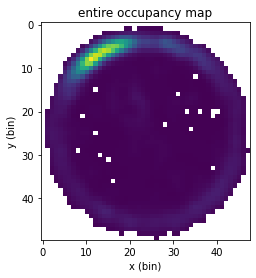

In [12]:
ap.occupancy_map_2d()
plt.imshow(ap.occupancy_map.T)
plt.xlabel("x (bin)")
plt.ylabel("y (bin)")
plt.title("entire occupancy map")
plt.show()

## Light/Dark Intervals

In [13]:
# get times from external time source
times = ses.log_times
print(times.shape)
print(times)

(42,)
[  32.76129544 1236.76036457 1360.76075603 1486.04656119 1610.52930834
 1735.19819967 1859.05137011 1982.70250531 2106.30396168 2230.5033565
 2354.156349   2477.85098164 2601.42878383 2725.11879079 2848.72952438
 2972.44954492 3096.57573801 3220.28369892 3343.88926256 3467.58951098
 3591.10176068 3714.79126207 3838.43165722 3962.10009863 4085.63276697
 4209.34457699 4332.95123819 4456.6114819  4580.1226897  4703.79440392
 4827.42261673 4951.09030518 5074.63235961 5198.34194294 5321.91841223
 5445.59893776 5569.19904679 5692.89286976 5816.50264924 5940.18734474
 6063.80821741 7267.38601876]


In [14]:
## artificially create light switches (not recommended, rather use clock sync)
## light_switches = times of light switched (on/off), starts with off, at 0s switched on
light_switches = [0.]
for i in range(2*20):
    p = 1200.+120.*i
    light_switches.append(p)
light_switches.append(p+1200)

# for i,l in enumerate(light_switches):
#    print("#",i," : ",l," (",(i+1)%2,")")

# light_dark_intervals = ap.times2intervals(light_switches)
# print(light_dark_intervals)

In [15]:
# create intervals from logged times
light_dark_intervals = ap.times2intervals(times)
print("Intervals:", light_dark_intervals.shape)
print("first: ",light_dark_intervals[0])
print("last: ",light_dark_intervals[-1])

Intervals: (41, 2)
first:  [  32.76129544 1236.76036457]
last:  [6063.80821741 7267.38601876]


In [16]:
for i,intv in enumerate(light_dark_intervals):
    print("#",i,":",intv,"-",np.diff(intv)[0],"sec","-","dark" if i%2 else "light","")

# 0 : [  32.76129544 1236.76036457] - 1203.9990691318883 sec - light 
# 1 : [1236.76036457 1360.76075603] - 124.00039145526102 sec - dark 
# 2 : [1360.76075603 1486.04656119] - 125.28580516071133 sec - light 
# 3 : [1486.04656119 1610.52930834] - 124.48274715021284 sec - dark 
# 4 : [1610.52930834 1735.19819967] - 124.66889132900064 sec - light 
# 5 : [1735.19819967 1859.05137011] - 123.85317044530325 sec - dark 
# 6 : [1859.05137011 1982.70250531] - 123.65113519645774 sec - light 
# 7 : [1982.70250531 2106.30396168] - 123.6014563689098 sec - dark 
# 8 : [2106.30396168 2230.5033565 ] - 124.19939481873053 sec - light 
# 9 : [2230.5033565 2354.156349 ] - 123.65299250068392 sec - dark 
# 10 : [2354.156349   2477.85098164] - 123.6946326374973 sec - light 
# 11 : [2477.85098164 2601.42878383] - 123.57780219007145 sec - dark 
# 12 : [2601.42878383 2725.11879079] - 123.69000696245166 sec - light 
# 13 : [2725.11879079 2848.72952438] - 123.61073359416241 sec - dark 
# 14 : [2848.72952438 2972.

In [17]:
# select the initial baseline
baseline_interval = light_dark_intervals[0]
print("baseline_interval",baseline_interval)

baseline_interval [  32.76129544 1236.76036457]


In [17]:
# select the initial baseline
baseline_interval = light_dark_intervals[0]
print("baseline_interval",baseline_interval)

baseline_interval [  32.76129544 1236.76036457]


In [18]:
# select the light/dark intervals

light_dark_intervals_without_baseline = light_dark_intervals[1:-1] # remove first and last interval (baselines)
#light_dark_intervals_without_baseline = light_dark_intervals[1:] # remove first baseline

dark_intervals = light_dark_intervals_without_baseline[::2] # every second interval is dark, starting from the first one
print("dark intervals (",len(dark_intervals),")")
print(dark_intervals)

print("")

light_intervals = light_dark_intervals_without_baseline[1::2] # every second interval is dark, starting from the second one
print("light intervals (",len(light_intervals),")")
print(light_intervals)

dark intervals ( 20 )
[[1236.76036457 1360.76075603]
 [1486.04656119 1610.52930834]
 [1735.19819967 1859.05137011]
 [1982.70250531 2106.30396168]
 [2230.5033565  2354.156349  ]
 [2477.85098164 2601.42878383]
 [2725.11879079 2848.72952438]
 [2972.44954492 3096.57573801]
 [3220.28369892 3343.88926256]
 [3467.58951098 3591.10176068]
 [3714.79126207 3838.43165722]
 [3962.10009863 4085.63276697]
 [4209.34457699 4332.95123819]
 [4456.6114819  4580.1226897 ]
 [4703.79440392 4827.42261673]
 [4951.09030518 5074.63235961]
 [5198.34194294 5321.91841223]
 [5445.59893776 5569.19904679]
 [5692.89286976 5816.50264924]
 [5940.18734474 6063.80821741]]

light intervals ( 19 )
[[1360.76075603 1486.04656119]
 [1610.52930834 1735.19819967]
 [1859.05137011 1982.70250531]
 [2106.30396168 2230.5033565 ]
 [2354.156349   2477.85098164]
 [2601.42878383 2725.11879079]
 [2848.72952438 2972.44954492]
 [3096.57573801 3220.28369892]
 [3343.88926256 3467.58951098]
 [3591.10176068 3714.79126207]
 [3838.43165722 3962.10

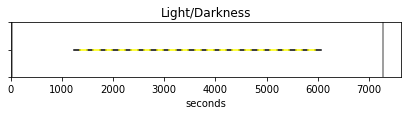

In [33]:
# visualize the light/dark intervals

plt.figure(figsize=(7,1))

plt.axvline(x=np.min(light_dark_intervals), color='grey')
plt.axvline(x=np.max(light_dark_intervals), color='grey')

plt.xlim((0,np.max(light_dark_intervals)*1.05))
plt.ylim((-0.5,0.5))
plt.gca().set(yticklabels=[])  

for dark_interval in dark_intervals:
    plt.plot(dark_interval, [0,0], color='black')
for light_interval in light_intervals:
    plt.plot(light_interval, [0,0], color='yellow')

plt.xlabel("seconds")

plt.title("Light/Darkness")

plt.show()


### **Initial Baseline**

Use the initial baseline (20min) to detect HD cells

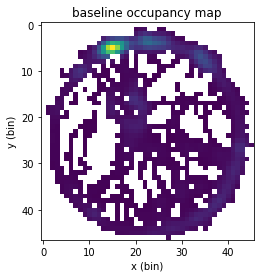

In [23]:
ap.set_intervals(baseline_interval)
ap.occupancy_map_2d()
plt.imshow(ap.occupancy_map.T)
plt.xlabel("x (bin)")
plt.ylabel("y (bin)")
plt.title("baseline occupancy map")
plt.show()

In [24]:
ap.invalid_ratio()

0.1746345514950166

In [25]:
occupancy = ap.occupancy(arena='circle')
print("occupancy: {:.1f} %".format(occupancy*100))

occupancy: 64.2 %


#### for each cell

interval used = [  32.76129544 1236.76036457]
i 0 / n 0
i 1 / n 3
i 2 / n 5
i 3 / n 14
i 4 / n 15
i 5 / n 20
i 6 / n 21
i 7 / n 23
i 8 / n 31
i 9 / n 32
i 10 / n 33
i 11 / n 34
i 12 / n 44
HD neuron 12
i 13 / n 47
HD neuron 13
i 14 / n 48
HD neuron 14
i 15 / n 49
HD neuron 15
i 16 / n 54
i 17 / n 55
i 18 / n 56
HD neuron 18
i 19 / n 59
HD neuron 19
i 20 / n 61
i 21 / n 62
i 22 / n 75
i 23 / n 99
i 24 / n 107
i 25 / n 113


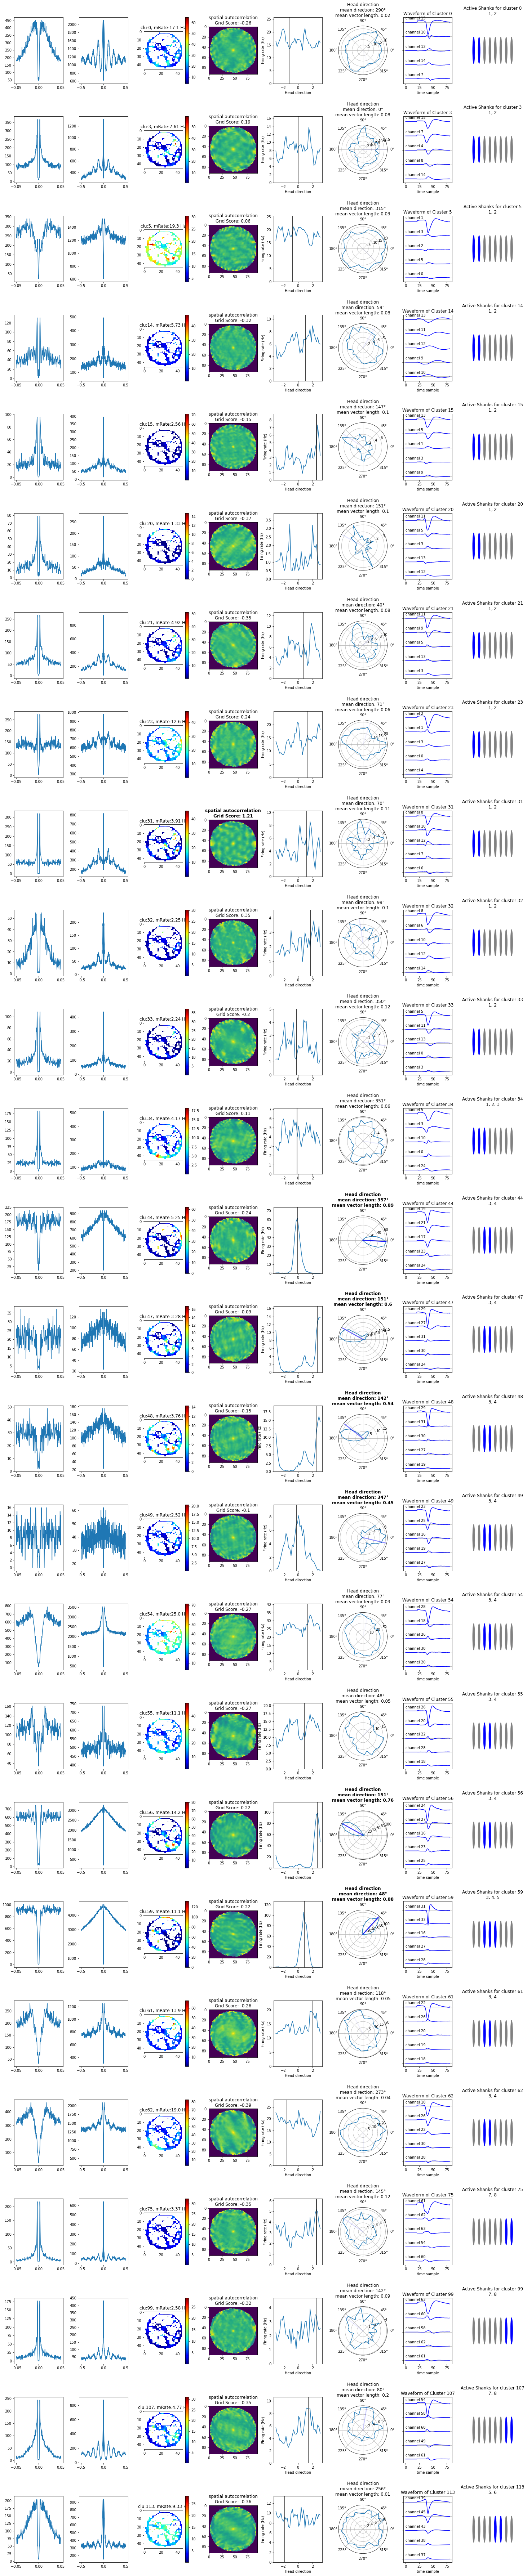

In [26]:
# make the analysis for the baseline only
iv=np.array(baseline_interval)
print("interval used =",iv)

hd_firing_list=[] # neurons tuning curve
hd_ifr_list=[] # ifr list
spike_trains = [] # spike trains
hd_neurons = [] ## list of ids of HD neurons

cg.set_spatial_properties(ap)

# from matplotlib.patches import Rectangle

cols = 8

fig, axs = plt.subplots(len(cg.neuron_list), cols, figsize=(25, 5*len(cg.neuron_list)))
   
for i, n in enumerate(cg.neuron_list):

    # reset and set intervals
    n.spike_train.unset_intervals()
    ap.unset_intervals()
    n.spike_train.set_intervals(iv)
    ap.set_intervals(iv)
    
    print("i",i,"/","n",n.name)
    # print("n",n.spike_train.intervals.total_interval_duration_seconds())
    # print("ap",ap.intervals.total_interval_duration_seconds())
    
    
    # temporal auto-correlation
      
    n.spike_train.spike_time_autocorrelation(bin_size_sec=0.0005,min_sec=-0.05, max_sec=0.05)
    timestamp = n.spike_train.mid_point_from_edges(n.spike_train.st_autocorrelation_histogram[1])
    axs[i,0].plot(timestamp, n.spike_train.st_autocorrelation_histogram[0])
    
    n.spike_train.spike_time_autocorrelation(bin_size_sec=0.0025,min_sec=-0.5, max_sec=0.5)
    timestamp = n.spike_train.mid_point_from_edges(n.spike_train.st_autocorrelation_histogram[1])
    axs[i,1].plot(timestamp, n.spike_train.st_autocorrelation_histogram[0])
    
    
    # spatial firing map 
    
    n.set_spatial_properties(ap)
    n.spatial_properties.firing_rate_map_2d(cm_per_bin =2, smoothing_sigma_cm = 2, smoothing=True)
    im = axs[i,2].imshow(n.spatial_properties.firing_rate_map,cmap='jet')
    axs[i,2].set_title("clu:{}, mRate:{:.3} Hz".format(n.name,n.spike_train.mean_firing_rate()))
    fig.colorbar(im,ax=axs[i,2])
    
    
    # Spatial autocorrelation Map & Grid Score
    gs = n.spatial_properties.grid_score()
    
    fw = "bold" if gs>.4 else "normal"
    
    axs[i,3].imshow(n.spatial_properties.spatial_autocorrelation_map)
    axs[i,3].set_title("spatial autocorrelation"+"\n"+"Grid Score: "+str(round(gs,2)), fontweight=fw)
    
    # Head direction
    
    n.spatial_properties.firing_rate_head_direction_histogram(smoothing=False)
    
    angles = n.spatial_properties.mid_point_from_edges(n.spatial_properties.firing_rate_head_direction_histo_edges)
    hd_firing = n.spatial_properties.firing_rate_head_direction_histo
    hd_mean_direction_rad, hd_mean_direction_deg, hd_mean_vector_length, hd_peak_angle_rad, hd_peak_rate = n.spatial_properties.head_direction_score()
    
    axs[i,4].plot(angles, hd_firing)
    axs[i,4].set_xlabel("Head direction")
    axs[i,4].set_ylabel("Firing rate (Hz)")
    axs[i,4].set_ylim(0,np.max(n.spatial_properties.firing_rate_head_direction_histo)*1.2)
    axs[i,4].axvline(x=hd_mean_direction_rad, color="black")
    #axs[i,4].text(s=str(round(hd_mean_direction_rad*180./np.pi))+" ° (vector length = "+str(hd_mean_vector_length)+")",x=hd_mean+.1,y=1)
    
    fw = "bold" if hd_mean_vector_length>.4 else "normal"
    axs[i,5].axis('off')
    ax2 = fig.add_subplot(len(cg.neuron_list), cols, cols*i+6, polar=True)
    #ax2.plot(angles, hd_firing)
    ax2.plot(np.append(angles,angles[0]), np.append(hd_firing,hd_firing[0]))
    ax2.plot([hd_mean_direction_rad]*2, [0,max(hd_firing)] , color="blue", alpha=hd_mean_vector_length, lw=2.5  )
    ax2.set_title("Head direction" + "\n" + "mean direction: " + str(round( (hd_mean_direction_deg + 360) % 360  )) +"°" + "\n" + "mean vector length: " + str(np.round(hd_mean_vector_length,2))  , fontweight=fw) 
    ax2.grid(True)
    
    
    # Waveforms
    
    cluster = int(n.name) # current cluster name
    channels = ses.get_channels_from_cluster(cluster) # get channels with highest amplitude
    
    if (len(channels)):
    
        for j,channel in enumerate(channels):
            channel_mapped, waveform = ses.get_waveform_from_cluster(cluster, channel)
            axs[i,6].axhline( y = -j*.5 , color="grey" , lw=.5 )
            #label = "channel: "+str(channel)+" ("+str(channel_mapped)+")"
            label = "channel "+str(channel_mapped)
            axs[i,6].plot( waveform -j*.5 , label=label , color="blue")
            axs[i,6].text( s= label , x=0, y=-j*.5 +.1 )
        axs[i,6].set_xlabel("time sample")
        axs[i,6].set(yticklabels=[])  
        axs[i,6].set_title("Waveform of Cluster "+str(cluster))
        
    # shanks
    shanks_arr, active_shanks, electrodes = ses.get_active_shanks(channels)
   
    for j, (shank, active) in enumerate(zip(ses.shanks_all, shanks_arr)):
        color = 'blue' if active else 'gray'
        circle = plt.Circle((j,0), 0.2, color=color)
        axs[i,7].add_patch(circle)

    
    axs[i,7].axis('off')
    axs[i,7].set_title("Active Shanks for cluster "+str(cluster)+"\n"+', '.join([str(int(active_shank)) for active_shank in active_shanks]))
    
    axs[i,7].set_xlim([-1, len(ses.shanks_all)])
    axs[i,7].set_ylim([-0.5, 0.5])
    
    ###########################
    # classify, find category: Grid cell, HD cell
    
    if (hd_mean_vector_length > 0.4):
        n.spike_train.instantaneous_firing_rate(bin_size_sec=2.e-2)
        # print("n.name",n.name)
        # print("n.spike_train.ifr",n.spike_train.ifr)
        # print("n.spike_train.st",n.spike_train.st)
        
        hd_firing_list.append(hd_firing)
        hd_ifr_list.append(n.spike_train.ifr)
        spike_trains.append(n.spike_train.st)
        
        hd_neurons.append(i)
        print("HD neuron",i)
        
        #rect = Rectangle((0.08, 1-(i+.5)/len(cg.neuron_list)), 0.85, 1/len(cg.neuron_list), facecolor='yellow', edgecolor='none', transform=fig.transFigure, zorder=-1)
        #fig.patches.append(rect)

    
    
#plt.tight_layout()
fig.subplots_adjust(wspace=0.33, hspace=.5)
# plt.savefig('/home/pascal/Documents/science_docs/analysis_results/'+name+'_baseline.pdf')
plt.show()


### After darkness (block-binning)

*define the blocks*

In [35]:
def intervals_to_blocks(intervals, blocks):
    intervals_divided = []
    
    for interval in intervals:
        interval_divided = np.linspace(interval[0],interval[1],blocks+1)
        intervals_divided.append(ap.times2intervals(interval_divided))
        
    intervals_divided_transposed = np.transpose(intervals_divided,(1,0,2))

    return intervals_divided_transposed

In [20]:
# convert intervals to blocks of 10 seconds duration

#blocks = 12 # 120 seconds / 12 blocks = 10 second per block
blocks=6

dark_intervals_divided = []

for dark_interval in dark_intervals:
    print("dark_interval:", dark_interval)
    dark_interval_divided = np.linspace(dark_interval[0],dark_interval[1],blocks+1)
    print("dark_interval_divided","(",len(dark_interval_divided),"steps )",":", dark_interval_divided)
    dark_intervals_divided.append(ap.times2intervals(dark_interval_divided))
    print("")

dark_interval: [1236.76036457 1360.76075603]
dark_interval_divided ( 7 steps ) : [1236.76036457 1257.42709648 1278.09382839 1298.7605603  1319.42729221
 1340.09402412 1360.76075603]

dark_interval: [1486.04656119 1610.52930834]
dark_interval_divided ( 7 steps ) : [1486.04656119 1506.79368571 1527.54081024 1548.28793476 1569.03505929
 1589.78218381 1610.52930834]

dark_interval: [1735.19819967 1859.05137011]
dark_interval_divided ( 7 steps ) : [1735.19819967 1755.84039474 1776.48258982 1797.12478489 1817.76697997
 1838.40917504 1859.05137011]

dark_interval: [1982.70250531 2106.30396168]
dark_interval_divided ( 7 steps ) : [1982.70250531 2003.30274804 2023.90299077 2044.5032335  2065.10347622
 2085.70371895 2106.30396168]

dark_interval: [2230.5033565 2354.156349 ]
dark_interval_divided ( 7 steps ) : [2230.5033565  2251.11218858 2271.72102067 2292.32985275 2312.93868483
 2333.54751692 2354.156349  ]

dark_interval: [2477.85098164 2601.42878383]
dark_interval_divided ( 7 steps ) : [2477.

In [21]:
dark_intervals_divided = np.transpose(dark_intervals_divided,(1,0,2))

print("dark_intervals_divided",dark_intervals_divided.shape)
print(dark_intervals_divided)

dark_intervals_divided (6, 20, 2)
[[[1236.76036457 1257.42709648]
  [1486.04656119 1506.79368571]
  [1735.19819967 1755.84039474]
  [1982.70250531 2003.30274804]
  [2230.5033565  2251.11218858]
  [2477.85098164 2498.447282  ]
  [2725.11879079 2745.72057972]
  [2972.44954492 2993.13724377]
  [3220.28369892 3240.8846262 ]
  [3467.58951098 3488.17488593]
  [3714.79126207 3735.39799459]
  [3962.10009863 3982.68887669]
  [4209.34457699 4229.94568719]
  [4456.6114819  4477.1966832 ]
  [4703.79440392 4724.39910605]
  [4951.09030518 4971.68064758]
  [5198.34194294 5218.93802116]
  [5445.59893776 5466.19895593]
  [5692.89286976 5713.49449968]
  [5940.18734474 5960.79082352]]

 [[1257.42709648 1278.09382839]
  [1506.79368571 1527.54081024]
  [1755.84039474 1776.48258982]
  [2003.30274804 2023.90299077]
  [2251.11218858 2271.72102067]
  [2498.447282   2519.04358237]
  [2745.72057972 2766.32236865]
  [2993.13724377 3013.82494262]
  [3240.8846262  3261.48555347]
  [3488.17488593 3508.76026088]
  [3

In [22]:
first_block = dark_intervals_divided[0] # first 10 seconds with darkness after light
print(first_block)

[[1236.76036457 1257.42709648]
 [1486.04656119 1506.79368571]
 [1735.19819967 1755.84039474]
 [1982.70250531 2003.30274804]
 [2230.5033565  2251.11218858]
 [2477.85098164 2498.447282  ]
 [2725.11879079 2745.72057972]
 [2972.44954492 2993.13724377]
 [3220.28369892 3240.8846262 ]
 [3467.58951098 3488.17488593]
 [3714.79126207 3735.39799459]
 [3962.10009863 3982.68887669]
 [4209.34457699 4229.94568719]
 [4456.6114819  4477.1966832 ]
 [4703.79440392 4724.39910605]
 [4951.09030518 4971.68064758]
 [5198.34194294 5218.93802116]
 [5445.59893776 5466.19895593]
 [5692.89286976 5713.49449968]
 [5940.18734474 5960.79082352]]


In [87]:
blocks = 12
light_intervals_divided = intervals_to_blocks(light_intervals, blocks)
dark_intervals_divided = intervals_to_blocks(dark_intervals, blocks)
print("light_intervals_divided", light_intervals_divided.shape)
print("dark_intervals_divided", dark_intervals_divided.shape)

light_intervals_divided (12, 19, 2)
dark_intervals_divided (12, 20, 2)


#### Pick some good HD neurons manually

#### **Analyse all HD neurons**

In [27]:
hd_neurons

[12, 13, 14, 15, 18, 19]

In [88]:
intervals = [baseline_interval, light_intervals, dark_intervals, None]
intervals.extend(light_intervals_divided)
intervals.extend(dark_intervals_divided)
#~ print(len(intervals),intervals)

labels = ["Baseline","all light","all darkness",None]
col_ids = [0, 1, 1, 2]

light_intervals_divided_labels = [ "light block {}".format(b+1) for b,i in enumerate(light_intervals_divided) ]
labels.extend(light_intervals_divided_labels)
col_ids.extend(range(3,3+len(light_intervals_divided_labels)))

dark_intervals_divided_labels = [ "darkness block {}".format(b+1) for b,i in enumerate(dark_intervals_divided) ]
labels.extend(dark_intervals_divided_labels)
col_ids.extend(range(3,3+len(dark_intervals_divided_labels)))


#~ print(labels)
width_ratios = [1, 1, 0.5] + blocks*[1]

legends = [False, True, True, None] + 2*blocks*[True]

#~ for col_id,interval,label,legend in zip(col_ids, intervals, labels, legends):
#~     print(col_id, interval.shape if not interval is None else 'None','"'+str(label)+'"',legend)

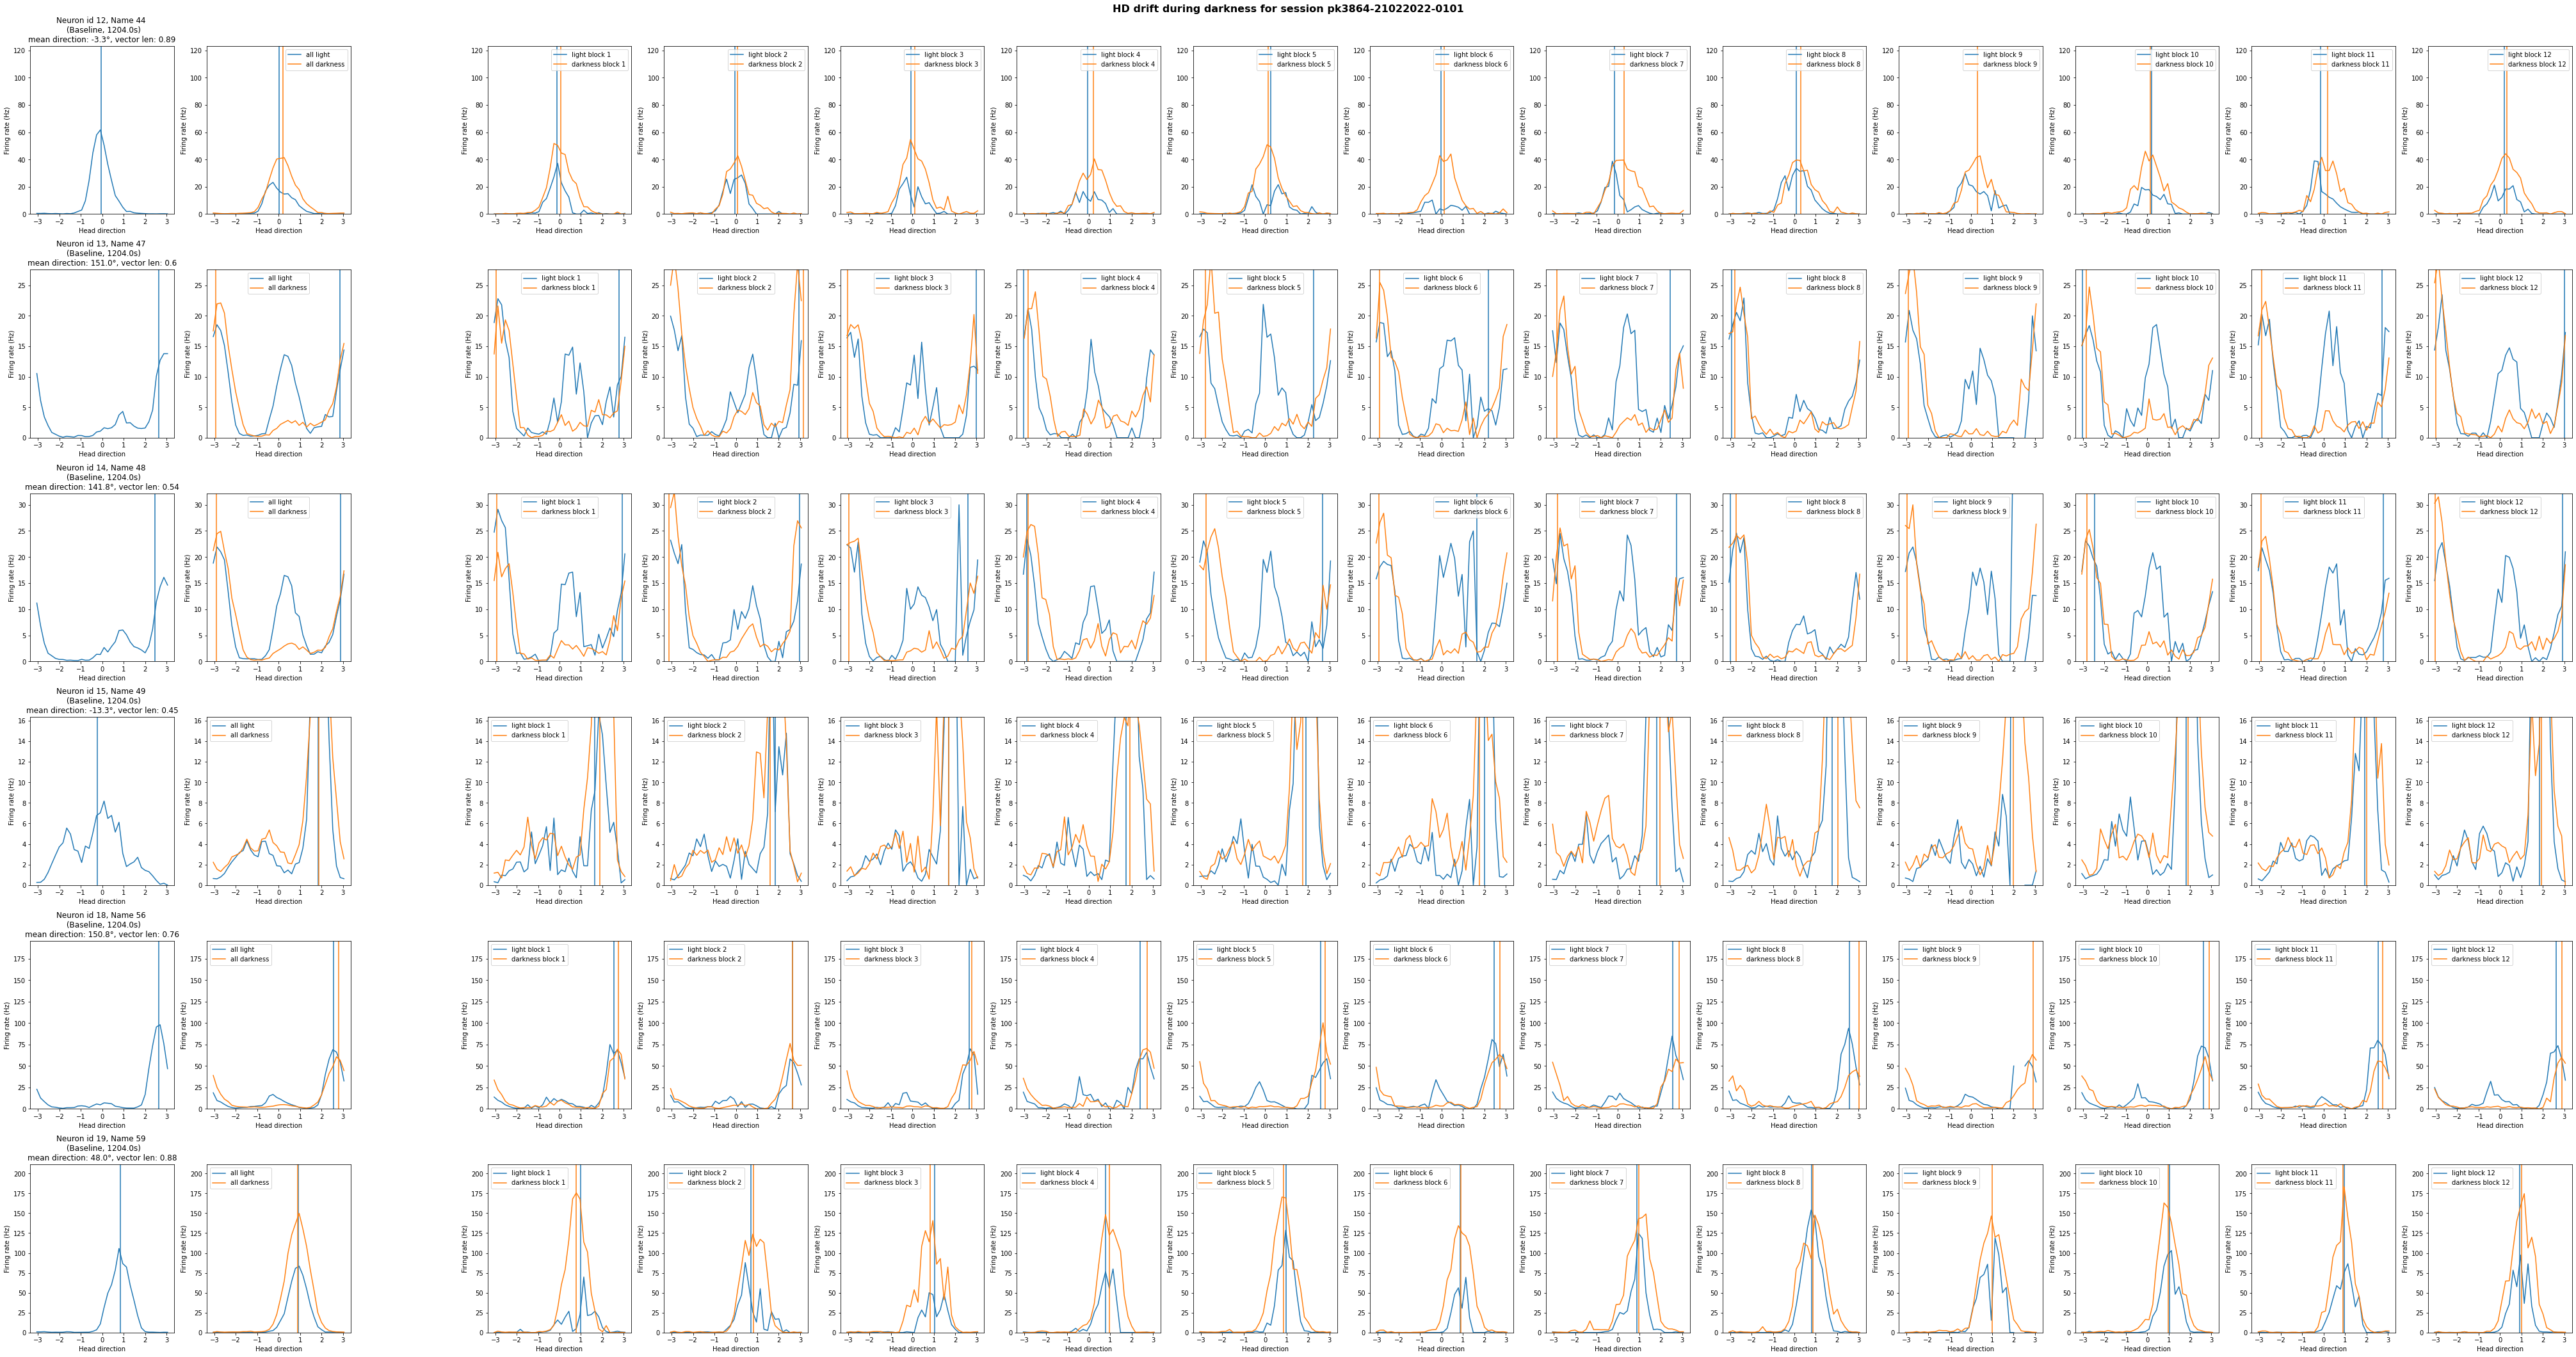

In [89]:
fig, axs = plt.subplots(len(hd_neurons), 2+1+blocks, figsize=(4*(2+blocks), 5*len(hd_neurons)), gridspec_kw={'width_ratios': width_ratios})
# rows,cols, figsize=(width,height)

for i,index in enumerate(hd_neurons):
    
    ## select neuron from list
    
    n = cg.neuron_list[index]
    
    
    ## HD tuning curve: first for references: baseline & darkness, then for each block in darkness (light respectively)
    
    #for j,(interval,label) in enumerate(zip(intervals,labels)):
    for col_id,interval,label,legend in zip(col_ids, intervals, labels, legends):
        
        j = col_id
        
        if interval is None:
            axs[i,j].set_visible(False)
            continue
        
        #~ print(j,(interval,label))
        #~ continue

        # reset and set intervals
        n.spike_train.unset_intervals()
        ap.unset_intervals()
        n.spike_train.set_intervals(interval)
        ap.set_intervals(interval)

        #~ print("n",n.spike_train.intervals.total_interval_duration_seconds())
        #~ print("ap",ap.intervals.total_interval_duration_seconds())
        total_duration = n.spike_train.intervals.total_interval_duration_seconds()

        n.set_spatial_properties(ap)

        n.spatial_properties.firing_rate_head_direction_histogram(smoothing=False)

        angles = n.spatial_properties.mid_point_from_edges(n.spatial_properties.firing_rate_head_direction_histo_edges)
        hd_firing = n.spatial_properties.firing_rate_head_direction_histo
        hd_mean_direction_rad, hd_mean_direction_deg, hd_mean_vector_length, hd_peak_angle_rad, hd_peak_rate = n.spatial_properties.head_direction_score()

        axs[i,j].plot(angles, hd_firing, label=label)
        axs[i,j].set_xlabel("Head direction")
        axs[i,j].set_ylabel("Firing rate (Hz)")
        if j==0:
            ymax = np.max(n.spatial_properties.firing_rate_head_direction_histo)*2. # first col defines y scaling
        axs[i,j].set_ylim(0,ymax)
        axs[i,j].axvline(x=hd_mean_direction_rad, color=axs[i,j].lines[-1].get_color())
        axs[i,j].set_title("Neuron id {}, Name {} \n ({}, {:.1f}s)".format(index,n.name,label,total_duration) + "\n" + "mean direction: {:.1f}°, vector len: {:.2}".format(hd_mean_direction_deg,hd_mean_vector_length))
        
        if (legend):
            axs[i,j].legend()
            axs[i,j].set_title('')
    
plt.suptitle("HD drift during darkness for session "+name, fontsize=16, fontweight='bold')
plt.tight_layout()
fig.subplots_adjust(top=0.95)
# plt.savefig('/home/pascal/Documents/science_docs/analysis_results/'+name+'_HD-drift.pdf')
plt.show()

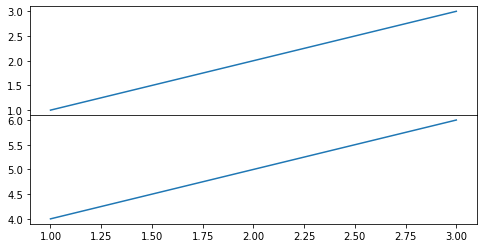

In [86]:
fig, axes = plt.subplots(ncols=1, nrows=2, sharex=True, sharey=False, figsize=(8,4))
fig.subplots_adjust(hspace=0)
axes[0].plot([1,2,3],[1,2,3])
axes[1].plot([1,2,3],[4,5,6])
plt.show()
